# **스마트폰 센서 데이터 기반 모션 분류**

## 단계 2. 기본 모델링

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers.legacy import Adam # MacOS
# from keras.optimizers import Adam # Windows
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

### Load Data

In [2]:
data = pd.read_csv('./data01_train.csv')

### Data Pre-Processing

In [3]:
# 사용하지 않을 변수 제거
data.drop('subject',axis=1, inplace=True)

#### (1) 데이터 분할

In [4]:
print(data.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)


In [5]:
X = data.drop('Activity',axis=1)
y = data['Activity']

In [25]:
# Y Label Encoder - 가변수화
l_enc = LabelEncoder() 
y_le = l_enc.fit_transform(y)

#### (2) 학습/검증 분리

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_le, test_size=.2, random_state=530, stratify=y)

### Modeling

#### (1) Support Vector Machine

In [9]:
# 모델 생성
svc=SVC(kernel='rbf',C=100.0)

# 모델 학습
svc.fit(X_train,y_train)

# 추론
svc_pred = svc.predict(X_valid)

#평가
print('accuracy :',accuracy_score(y_valid, svc_pred))
print('='*60)
print(confusion_matrix(y_valid, svc_pred))
print('='*60)
print(classification_report(y_valid, svc_pred))

accuracy : 0.989804587935429
[[223   0   0   0   0   0]
 [  0 196   9   0   0   1]
 [  0   2 216   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   0 158   0]
 [  0   0   0   0   0 172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.99      0.95      0.97       206
           2       0.96      0.99      0.98       218
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       158
           5       0.99      1.00      1.00       172

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



#### (2) XGBoost

In [13]:
# 모델 생성
xgb = XGBClassifier()

# 모델 학습
xgb.fit(X_train,y_train)

# 추론
xgb_pred = xgb.predict(X_valid)

#평가
print('accuracy :',accuracy_score(y_valid, xgb_pred))
print('='*60)
print(confusion_matrix(y_valid, xgb_pred))
print('='*60)
print(classification_report(y_valid, xgb_pred))

accuracy : 0.989804587935429
[[223   0   0   0   0   0]
 [  0 199   7   0   0   0]
 [  0   2 216   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   1 156   1]
 [  0   0   0   1   0 171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.99      0.97      0.98       206
           2       0.97      0.99      0.98       218
           3       0.99      1.00      1.00       200
           4       1.00      0.99      0.99       158
           5       0.99      0.99      0.99       172

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



#### DNN

In [15]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
# 모델 정의
clear_session()
def get_model(n_input):
    model = Sequential()
    model.add(Dense(256, input_dim=n_input, activation='elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(6, activation='softmax'))
    model.compile( optimizer=Adam(learning_rate= 0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
   
dnn_1 = get_model(X_train.shape[1])
dnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 185414 (724.27 KB)
Trainable params: 185414 (724.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
es = EarlyStopping(monitor = 'val_loss', patience = 20)

hist_1 = dnn_1.fit(X_train,y_train,epochs=150,
                   validation_split=.2,verbose=0,
                   callbacks = [es], batch_size=32).history

2024-03-27 22:17:58.856160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


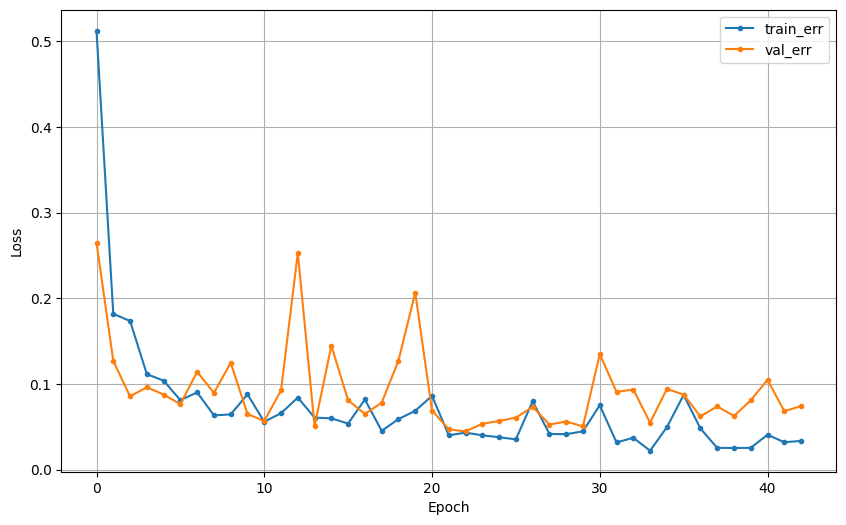

In [18]:
dl_history_plot(hist_1)

In [19]:
pred_1 = dnn_1.predict(X_valid)
pred_1 = pred_1.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_valid, pred_1))
print('='*60)
print(confusion_matrix(y_valid, pred_1))
print('='*60)
print(classification_report(y_valid, pred_1))

37/37 [==============================] - 0s 4ms/step
accuracy : 0.9753610875106202
[[223   0   0   0   0   0]
 [  1 194  10   0   0   1]
 [  0   9 209   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   0 150   8]
 [  0   0   0   0   0 172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.96      0.94      0.95       206
           2       0.95      0.96      0.96       218
           3       1.00      1.00      1.00       200
           4       1.00      0.95      0.97       158
           5       0.95      1.00      0.97       172

    accuracy                           0.98      1177
   macro avg       0.98      0.97      0.98      1177
weighted avg       0.98      0.98      0.98      1177



#### DNN(One-Hot Encoding)

In [20]:
# 라벨을 원-핫 인코딩으로 변환
y_train_oh = to_categorical(y_train, num_classes=6)

In [21]:
# 모델 정의
clear_session()
def get_model_oh(n_input):
    model = Sequential()
    model.add(Dense(256, input_dim=n_input, activation='elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(6, activation='softmax'))
    model.compile( optimizer=Adam(learning_rate= 0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
   
dnn_2 = get_model_oh(X_train.shape[1])
dnn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 185414 (724.27 KB)
Trainable params: 185414 (724.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
es = EarlyStopping(monitor = 'val_loss', patience = 20)

hist_2 = dnn_2.fit(X_train,y_train_oh,epochs=150,
                   validation_split=.2,verbose=0,
                   callbacks = [es], batch_size=32).history

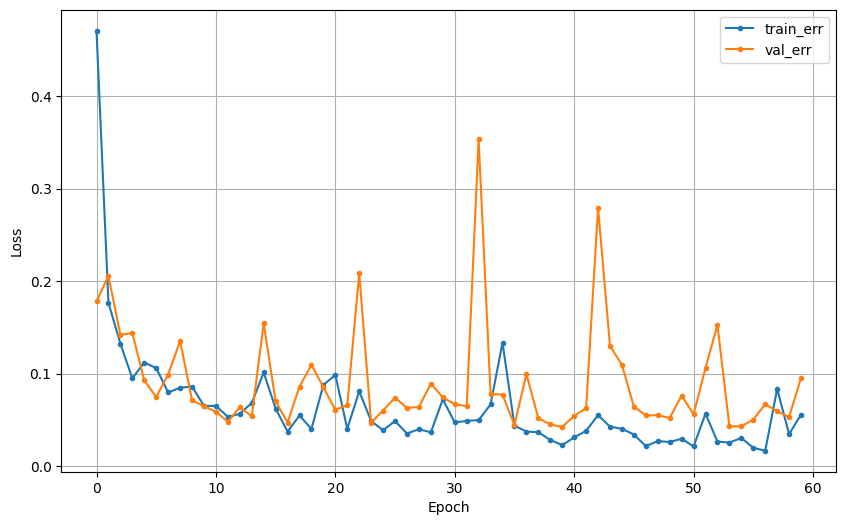

In [23]:
dl_history_plot(hist_2)

In [24]:
pred_2 = dnn_2.predict(X_valid)
pred_2 = pred_2.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_valid, pred_2))
print('='*60)
print(confusion_matrix(y_valid, pred_2))
print('='*60)
print(classification_report(y_valid, pred_2))

37/37 [==============================] - 0s 3ms/step
accuracy : 0.9753610875106202
[[223   0   0   0   0   0]
 [  0 188  17   0   0   1]
 [  0   4 213   0   0   1]
 [  0   0   0 200   0   0]
 [  0   0   0   0 158   0]
 [  0   0   0   0   6 166]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.98      0.91      0.94       206
           2       0.93      0.98      0.95       218
           3       1.00      1.00      1.00       200
           4       0.96      1.00      0.98       158
           5       0.99      0.97      0.98       172

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### 성능비교

In [26]:
test_data = pd.read_csv('./data01_test.csv')
test_data.drop('subject', axis=1, inplace=True)

x_test = test_data.drop('Activity',axis=1)
y_test = test_data['Activity']

y_test_le = l_enc.transform(y_test)

#### SVC Predict

In [27]:
# 추론
pred_svc = svc.predict(x_test)

#평가
print('accuracy :',accuracy_score(y_test_le, pred_svc))
print('='*60)
print(confusion_matrix(y_test_le, pred_svc))
print('='*60)
print(classification_report(y_test_le, pred_svc))

accuracy : 0.9870836165873556
[[292   0   0   0   0   0]
 [  0 246   8   0   0   0]
 [  0  10 277   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   0 195   0]
 [  0   0   0   1   0 214]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.97      0.96       254
           2       0.97      0.97      0.97       287
           3       1.00      1.00      1.00       228
           4       1.00      1.00      1.00       195
           5       1.00      1.00      1.00       215

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



#### XGBoost Predict

In [28]:
# 추론
pred_xgb = xgb.predict(x_test)

#평가
print('accuracy :',accuracy_score(y_test_le, pred_xgb))
print('='*60)
print(confusion_matrix(y_test_le, pred_xgb))
print('='*60)
print(classification_report(y_test_le, pred_xgb))

accuracy : 0.9857239972807614
[[291   0   0   0   0   1]
 [  0 245   9   0   0   0]
 [  0   4 282   0   0   1]
 [  0   0   0 225   0   3]
 [  0   0   0   2 193   0]
 [  0   0   0   1   0 214]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.96      0.97       254
           2       0.97      0.98      0.98       287
           3       0.99      0.99      0.99       228
           4       1.00      0.99      0.99       195
           5       0.98      1.00      0.99       215

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



#### DNN Predict

In [30]:
pred_dnn_1 = dnn_1.predict(x_test)
pred_dnn_1 = pred_dnn_1.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_test_le, pred_dnn_1))
print('='*60)
print(confusion_matrix(y_test_le, pred_dnn_1))
print('='*60)
print(classification_report(y_test_le, pred_dnn_1))

46/46 [==============================] - 0s 3ms/step
accuracy : 0.9748470428280082
[[292   0   0   0   0   0]
 [  0 243  11   0   0   0]
 [  0  16 271   0   0   0]
 [  0   0   2 226   0   0]
 [  0   0   0   0 189   6]
 [  0   0   1   1   0 213]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.94      0.96      0.95       254
           2       0.95      0.94      0.95       287
           3       1.00      0.99      0.99       228
           4       1.00      0.97      0.98       195
           5       0.97      0.99      0.98       215

    accuracy                           0.97      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.97      0.97      1471



#### DNN(One-Hot Encoding) Predict

In [31]:
y_test_oh = to_categorical(y_test_le, num_classes=6)

pred_dnn_2 = dnn_2.predict(x_test)
pred_dnn_2 = pred_dnn_2.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_test_le, pred_dnn_2))
print('='*60)
print(confusion_matrix(y_test_le, pred_dnn_2))
print('='*60)
print(classification_report(y_test_le, pred_dnn_2))

46/46 [==============================] - 0s 3ms/step
accuracy : 0.9789259007477906
[[292   0   0   0   0   0]
 [  0 239  13   0   0   2]
 [  0   7 278   0   0   2]
 [  0   0   0 223   1   4]
 [  0   0   0   0 195   0]
 [  0   0   0   1   1 213]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.97      0.94      0.96       254
           2       0.96      0.97      0.96       287
           3       1.00      0.98      0.99       228
           4       0.99      1.00      0.99       195
           5       0.96      0.99      0.98       215

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471

